In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

#qiskit
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, TwoLocal, RealAmplitudes
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC, NeuralNetworkClassifier 
from qiskit.aqua.algorithms import VQC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from IPython.display import clear_output
from typing import Union

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Cleveland Dataset.csv')

## Feature selection

In [81]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

X = data.drop(['target'] ,axis="columns")
y = data['target']

estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(X, y)

In [82]:
from operator import itemgetter
features = X.columns.to_list()
for x, y in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 sex
1 cp
1 exang
1 slope
1 ca
1 thal
2 oldpeak
3 restecg
4 fbs
5 thalach
6 trestbps
7 age
8 chol


# Classical classifiers 

## SVM

In [35]:
# classical SVM
X = data[['ca','cp','thal','exang','slope']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create svm Classifier
ClassifierSVM = SVC()

# Train the model using the training set
ClassifierSVM.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = ClassifierSVM.predict(X_test)

# Model Accuracy: 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8524590163934426


### SVM performance

In [36]:
# classification report of SVM
expected_y  = y_test
predicted_y = ClassifierSVM.predict(X_test) 

# print classification report and confusion matrix for svm classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Confusion matrix: 
 [[24  5]
 [ 4 28]]


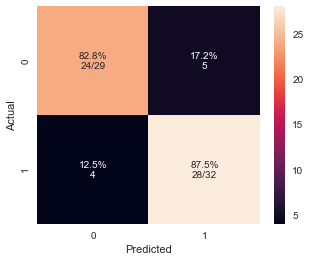

In [37]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

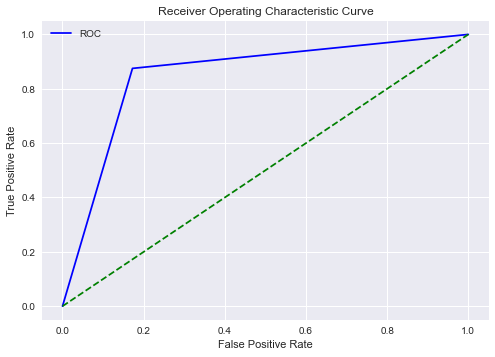

In [66]:
# ROC curve of SVM
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## ANN

In [140]:
# classical QNN 
X = data[['ca','cp','thal','exang','slope']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = MLPClassifier(max_iter=1000,  random_state=5)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.85245902]


In [57]:
# classification report of ANN
expected_y  = y_test
predicted_y = model.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Confusion matrix: 
 [[25  4]
 [ 5 27]]


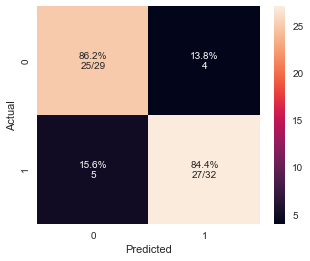

In [58]:
# confusion matrix of ANN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

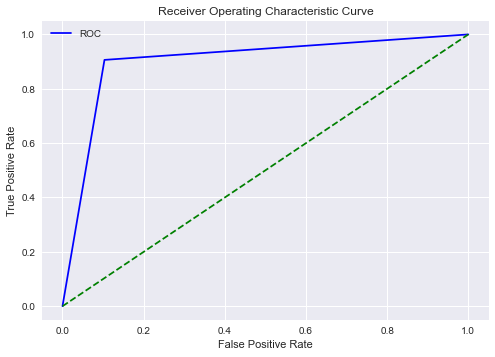

In [142]:
# ROC curve of ANN
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

# Quantum classifiers 

   ## QSVC

In [28]:
X = data[['ca','cp','thal','exang','slope']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

samples = np.append(X_train, X_test, axis=0)
minmax_scaler = MinMaxScaler((0, 1)).fit(samples)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [29]:
# number of qubits is equal to the number of features
num_qubits = 5
# regularization parameter
C = 1000

In [30]:
algorithm_globals.random_seed = 12345

backend = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
qsvc = QSVC(quantum_kernel=qkernel, C=C)

In [31]:
# training
qsvc.fit(X_train,y_train)

# testing
qsvc_score = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.8852459016393442


### QSVC performance

In [32]:
# classification report of QSVC
expected_y  = y_test
predicted_y = qsvc.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Confusion matrix: 
 [[26  3]
 [ 4 28]]


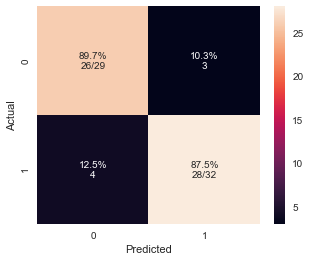

In [33]:
# confusion matrix of QSVC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

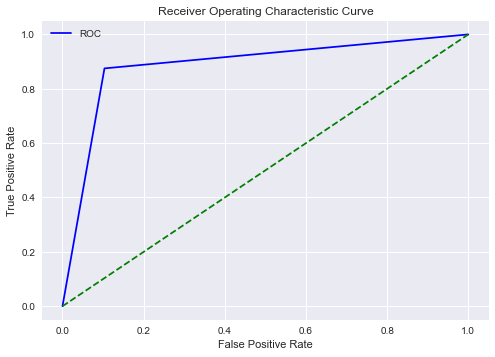

In [34]:
# ROC curve of QSVC
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## QNN

In [3]:
algorithm_globals.random_seed = 42
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [4]:
X = data[['ca','cp','thal','exang','slope']]
y = data['target']

std_scaler = StandardScaler().fit(X)
X = std_scaler.transform(X)
    
pca = PCA(n_components=2).fit(X)
X = pca.transform(X)

minmax_scaler = MinMaxScaler((0, 1)).fit(X)
X = minmax_scaler.transform(X)

# for cross validation
X_df = pd.DataFrame(X, columns = ['A','B'])

num_inputs = 2

In [5]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
# Classification with a CircuitQNN
# construct feature map
feature_map = ZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=2) 

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose()

In [7]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping

In [8]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [9]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
            neural_network=circuit_qnn, optimizer= L_BFGS_B(), loss='absolute_error', callback=callback_graph
)

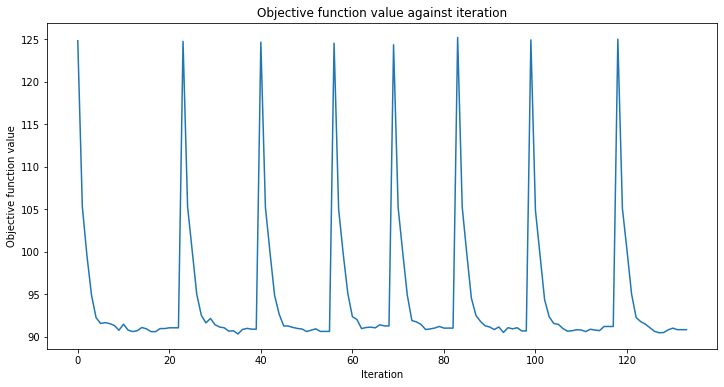

Final prediction score: [0.86842105]


In [10]:
# cross validation
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

kf = KFold(n_splits = 8, shuffle = True, random_state= 1)
scores = []
for i in range(8):
    result = next(kf.split(X_df), None)
    x_train = X_df.iloc[result[0]]
    x_test = X_df.iloc[result[1]]
    y_train = y.iloc[result[0]]
    y_test = y.iloc[result[1]]
    circuit_classifier.fit(x_train,y_train)
    y_pred = circuit_classifier.predict(x_test)
    
plt.rcParams["figure.figsize"] = (6, 4)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

### QNN performance

In [11]:
# classification report of QNN
expected_y  = y_test
predicted_y = circuit_classifier.predict(x_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.83      0.95      0.88        20

    accuracy                           0.87        38
   macro avg       0.88      0.86      0.87        38
weighted avg       0.88      0.87      0.87        38

Confusion matrix: 
 [[14  4]
 [ 1 19]]


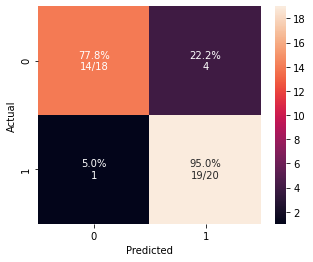

In [12]:
# confusion matrix of QNN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

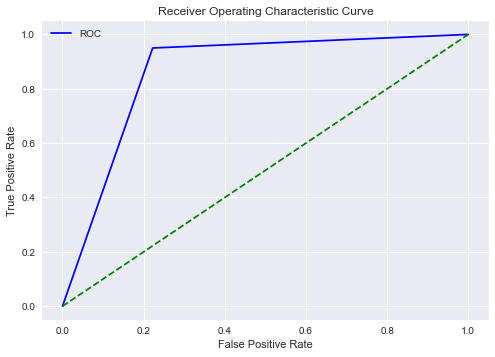

In [13]:
# ROC curve of QNN
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

## VQC

In [16]:
X = data.drop(['target','chol', 'trestbps','age'],axis="columns")
y = data['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

std_scaler = StandardScaler().fit(X_train)
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)
    
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

samples = np.append(X_train, X_test, axis=0)
minmax_scaler = MinMaxScaler((0, 1)).fit(samples)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

labels = [0,1]
training_input = {key: (X_train[y_train == k, :]) for k, key in enumerate(labels)}
test_input = {key: (X_test[y_test == k, :]) for k, key in enumerate(labels)}

In [18]:
feature_dim = 2
random_seed = 10489
shots = 1024
backend = BasicAer.get_backend('statevector_simulator')
optimizer = SPSA()
optimizer.set_options(save_steps=1)
feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=2)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=random_seed, seed_transpiler=random_seed)

In [19]:
result = vqc.run(quantum_instance)
print("Quantum accuracy on test set: {0}%".format(round(result['testing_accuracy']*100, 2)))

Quantum accuracy on test set: 86.89%


### VQC performance

In [21]:
# classification report of VQC
expected_y  = y_test
predicted_y = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Confusion matrix: 
 [[24  5]
 [ 3 29]]


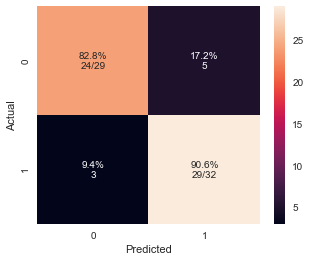

In [25]:
# confusion matrix of VQC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

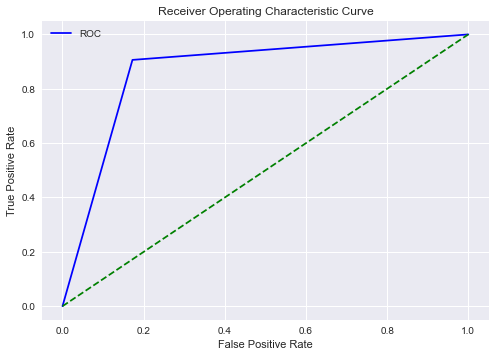

In [26]:
# ROC curve of VQC
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)

# Proposed model 

## Bagging-QSVC

In [60]:
# Pipeline Estimator
pipeline = make_pipeline(MinMaxScaler(), qsvc)

# Instantiate the bagging classifier
bgclassifier = BaggingClassifier(base_estimator=pipeline, n_estimators=100, 
                                 random_state=1, n_jobs=-1)

# Fit the bagging classifier
bgclassifier.fit(X_train, y_train)

# Model scores on test and training data
print('Model test Score: %.4f, ' %bgclassifier.score(X_test, y_test),
      'Model training Score: %.4f' %bgclassifier.score(X_train, y_train))

Model test Score: 0.9016,  Model training Score: 0.9008


### Bagging-QSVC performace

In [61]:
# classification report of Bagging-QSVC
expected_y  = y_test
predicted_y = bgclassifier.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(expected_y, predicted_y))
print("Confusion matrix: \n", metrics.confusion_matrix(expected_y, predicted_y))

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Confusion matrix: 
 [[26  3]
 [ 3 29]]


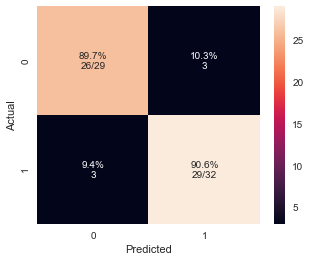

In [62]:
# confusion matrix of Bagging-QSVC
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, predicted_y, labels=[0,1], ymap=None, figsize=(5,4)) 

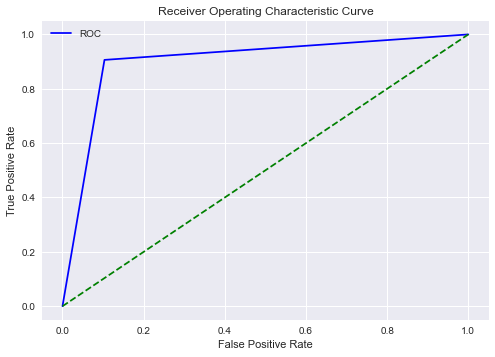

In [63]:
# ROC curve of Bagging-QSVC
from sklearn.metrics import roc_curve
plt.style.use('seaborn')

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(expected_y, predicted_y)
plot_roc_curve(fper, tper)